## Ankita replicado

In [3]:
from tqdm import tqdm
import os
import json
import numpy as np

In [4]:
def linear_CKA(X, Y):
    X_centered = X - X.mean(axis=0)
    Y_centered = Y - Y.mean(axis=0)
    hsic = np.linalg.norm(X_centered.T @ Y_centered, 'fro') ** 2
    var1 = np.linalg.norm(X_centered.T @ X_centered, 'fro')
    var2 = np.linalg.norm(Y_centered.T @ Y_centered, 'fro')

    return hsic / (var1 * var2)

In [5]:
wav_vs_glove = []
with open(os.path.join('../experiments/layers/embeddings_layer0_glove.json'), 'r') as f:
    glove_list = json.load(f)
glove_matrix = np.array(glove_list)

for i in range(12):
    with open(os.path.join('..', 'experiments', 'layers', f'embeddings_layer{i}_wav2vec2.json'), 'r') as f:
        model1_list = json.load(f)
    model1_matrix = np.array(model1_list)
    wav_vs_glove.append(linear_CKA(model1_matrix, glove_matrix)) 
   
with open(f'cka_glove_wav2vec2.json', 'w') as f:
    json.dump(wav_vs_glove, f)

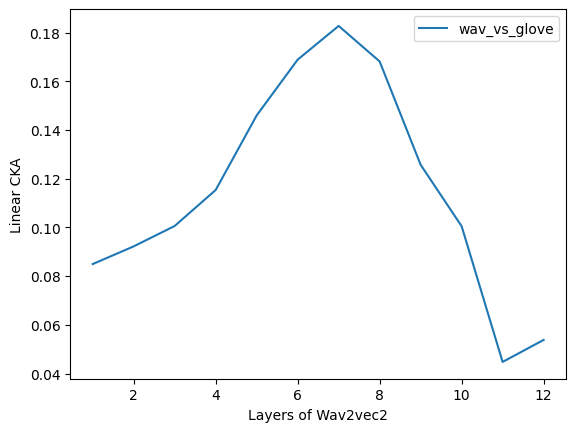

In [6]:
import matplotlib.pyplot as plt

x = range(1,13)
plt.plot(x, wav_vs_glove, label='wav_vs_glove')

plt.xlabel('Layers of Wav2vec2')
plt.ylabel('Linear CKA')
plt.legend()
plt.show()

## CKA: Learning Curve

In [7]:
x_list = []
for i in range(12):
    with open(os.path.join('..', 'experiments', 'layers', f'embeddings_layer{i}_wav2vec2.json'), 'r') as f:
        model1_list = json.load(f)
    x_matrix = np.array(model1_list)
    x_list.append(x_matrix) 


KeyboardInterrupt: 

In [ ]:
from tqdm import tqdm
matrix = np.zeros((30, 12))
for i in tqdm(range(1500, 46000, 1500)):
    index = int((i-1500)/1500)
    for j in tqdm(range(12)): 
        x = x_list[j]
        matrix[index, j] = linear_CKA(x[0:i], glove_matrix[0:i])

NameError: name 'np' is not defined

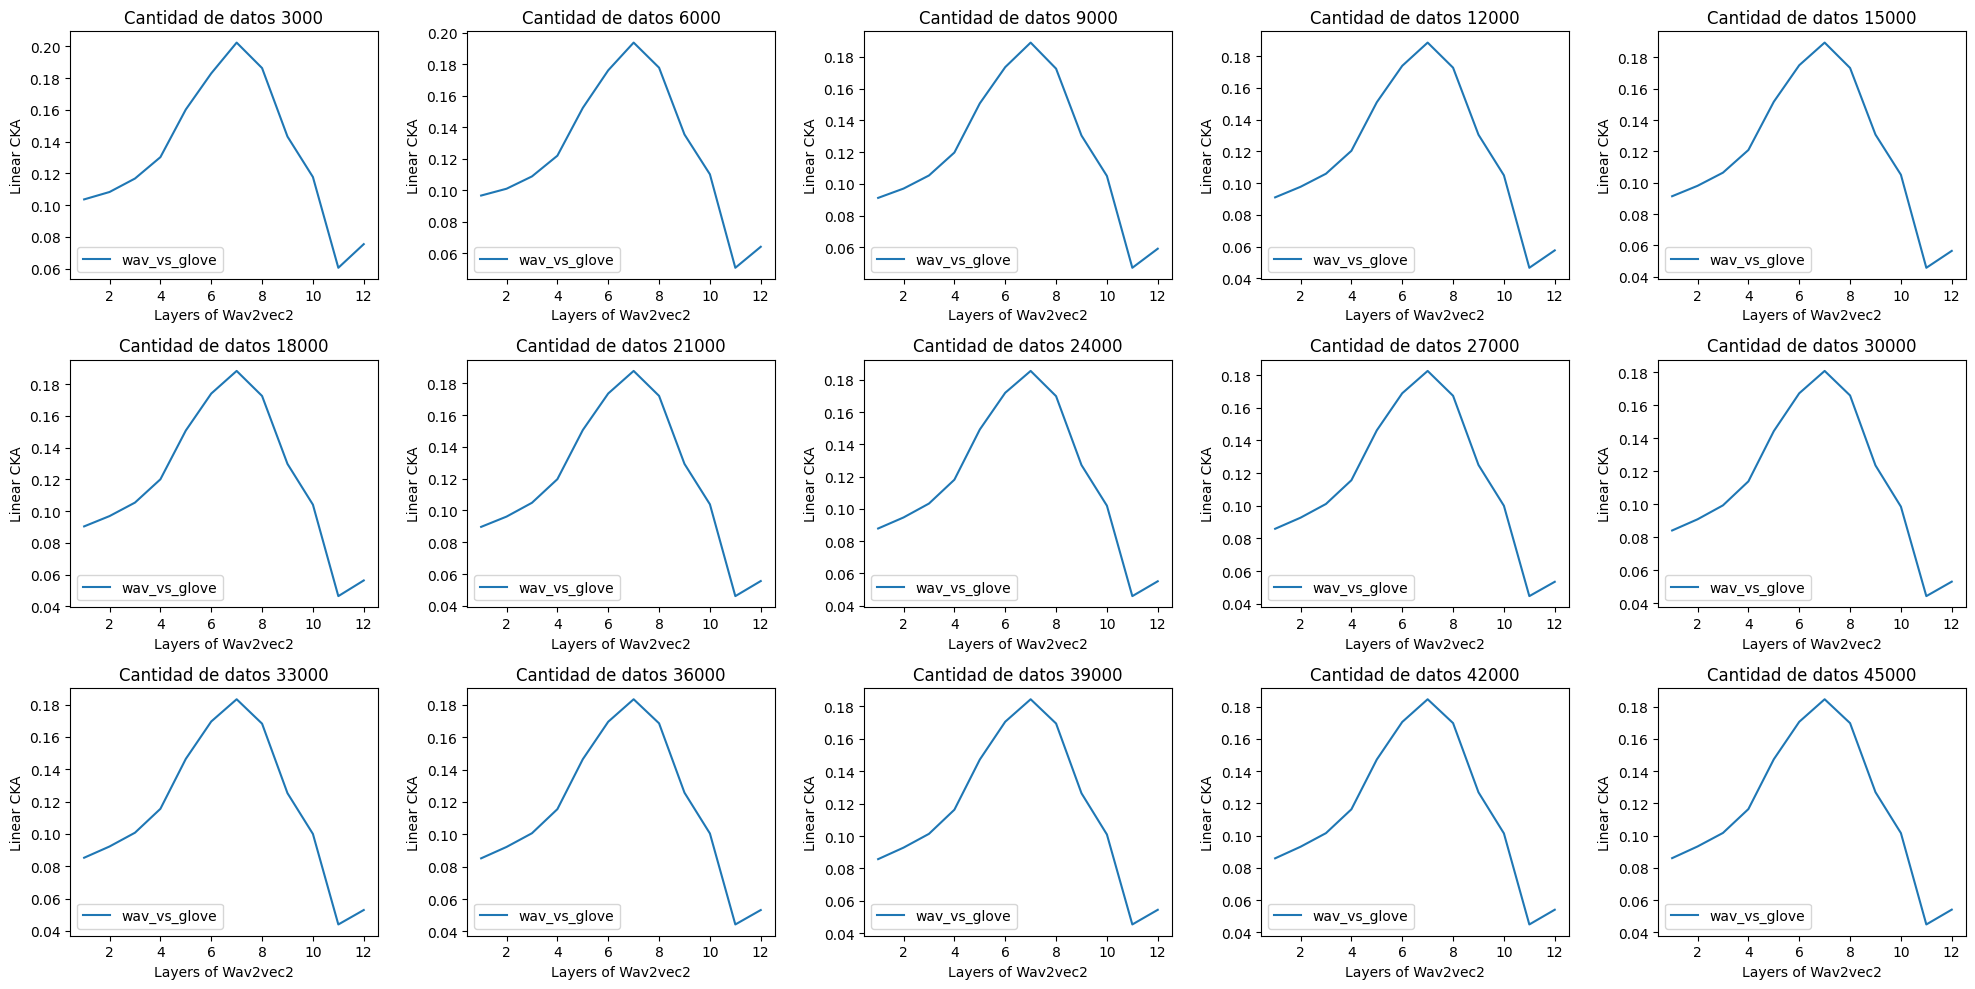

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'matrix' is already filled and has shape (15, 11)
# Setting up the figure and the axes grid
fig, axes = plt.subplots(nrows=6, ncols=5, figsize=(20, 10))  # Adjust figsize to fit your screen and needs

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i in range(15):
    x = range(1, 13)  # Layers 1 to 11
    axes[i].plot(x, matrix[i], label=f'wav_vs_glove')
    axes[i].set_xlabel('Layers of Wav2vec2')
    axes[i].set_ylabel('Linear CKA')
    axes[i].legend()
    axes[i].set_title(f'Cantidad de datos {(i+1)*3000}')  # Optional: add a title to each subplot

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


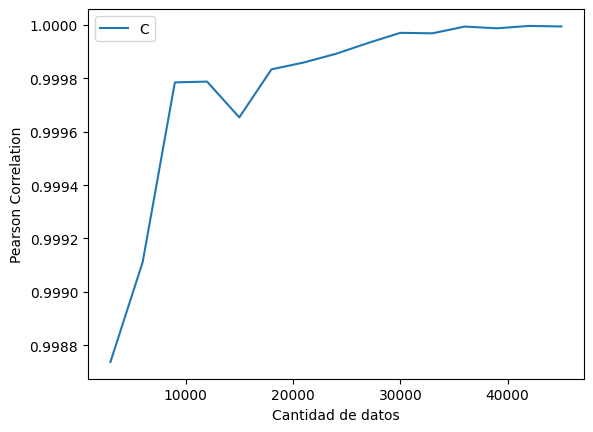

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt

pearson_corr = []
for i in range(matrix.shape[0]):
    pearson_corr.append(stats.pearsonr(wav_vs_glove, matrix[i]).statistic)

plt.plot(range(1500, 46000, 1500), pearson_corr)
plt.xlabel('Cantidad de datos')
plt.ylabel('Pearson Correlation')
plt.legend('Correlación de pearson entre la curva genereada con x cantidad de datos y la curva generada con 46000 datos')
plt.show()

## CKA vs CCA

In [ ]:
import os
os.environ['OMP_NUM_THREADS']='8' #Cantidad de threads a usar por sklearn
os.nice(10) #Prioridad de los procesos -20: highest 20: lowest 0: default

from sklearn.cross_decomposition import CCA
import numpy as np

wav_vs_glove = []
with open(os.path.join('../experiments/layers/embeddings_layer0_glove.json'), 'r') as f:
    glove_list = json.load(f)
glove_matrix = np.array(glove_list)

for i in range(12):
    x = x_list[i]
    model1_matrix = np.array(model1_list)
    model = CCA(n_components=300)
    model.fit(x[0:3000],glove_matrix[0:3000])
    wav_vs_glove.append(linear_CKA(model1_matrix, glove_matrix)) 
   
X_c, Y_c = model.transform(x, y)
correlations = np.corrcoef(X_c.T, Y_c.T).diagonal(offset=X_c.shape[1])

# Calculate the mean of the canonical correlations
mean_correlation = np.mean(correlations)